Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan of to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The loans files are very large (see below), so much time has been spent on cleaning, scrubbing, and casting datatypes. In order to form some initial conclusions, I'll need to sample the entire dataset (45k observations).  

My project goal is to look at the lending club data to form an opinion of the following: 
a) What are the best predictors of borrower default? 
b) What are the best predictors of early borrower repayment? 
c) What rates do borrowers pay versus their other financial options?

Ultimately, I would like to also use complementary external data sources to allow better prediction.  

In [60]:
# load relevant libraries
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns

%matplotlib inline

#import dataset
# This dataset has already benn slightly scrubbed - first line removed, gaps in middle removed
# I  don't know why I need to use 'unicode' to avoid memory error message.  
# Also, check why if header = 1 is used we seem to propogate NaN.
# Check file integrity of original file - noted gaps in the file used, manually correct. 
# lcd_raw = pd.read_csv(url,dtype='unicode')
# Two URLs which can be used:  i) LendingClub_07-12_Approved.csv
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved.csv"
#  
#                              iii) LendingClub_2014_Approved.csv
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved_mod.csv"

url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved_29MAY.csv"
lcd_raw = pd.read_csv(url,skiprows=1,
            parse_dates=['last_pymnt_d','issue_d','last_credit_pull_d','last_pymnt_d','next_pymnt_d'])

In [61]:
# Clean bottom of file and create new dataframe from it....
lcd_raw_clean = lcd_raw[:-4].copy()
lcd_raw_clean.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
42529,74505,74469,2000,2000,225,36 months,9.96%,64.50,B,B5,...,0.00,Jul-2010,0.84,Aug-2010,Jul-2010,594,590,NaN,NaN,1
42530,74323,74301,6500,6500,0,36 months,9.64%,208.66,B,B4,...,1714.27,May-2008,208.65,Dec-2008,Apr-2015,624,620,NaN,NaN,1
42531,73582,73096,3500,3500,225,36 months,10.28%,113.39,C,C1,...,0.00,Mar-2008,0.00,Mar-2008,Feb-2013,819,815,NaN,NaN,1
42532,72998,72992,1000,1000,0,36 months,9.64%,32.11,B,B4,...,0.00,Jun-2010,32.41,Jul-2010,Sep-2014,784,780,NaN,NaN,1
42533,72176,70868,2525,2525,225,36 months,9.33%,80.69,B,B3,...,0.00,Jun-2010,82.03,Jul-2010,May-2007,714,710,NaN,NaN,1


In [4]:
# Summarize the nulls in the data....
lcd_raw_clean.isnull().sum()

id                                 0
member_id                          1
loan_amnt                          1
funded_amnt                        1
funded_amnt_inv                    1
term                               1
int_rate                           1
installment                        1
grade                              1
sub_grade                          1
emp_title                       2624
emp_length                         1
home_ownership                     1
annual_inc                         4
verification_status                1
issue_d                            0
loan_status                        1
pymnt_plan                         1
url                                1
desc                           13293
purpose                            1
title                             13
zip_code                           1
addr_state                         1
dti                                1
delinq_2yrs                       28
earliest_cr_line                  28
f

In [5]:
# lcd_raw_clean['collections_12_mths_ex_med'].describe()

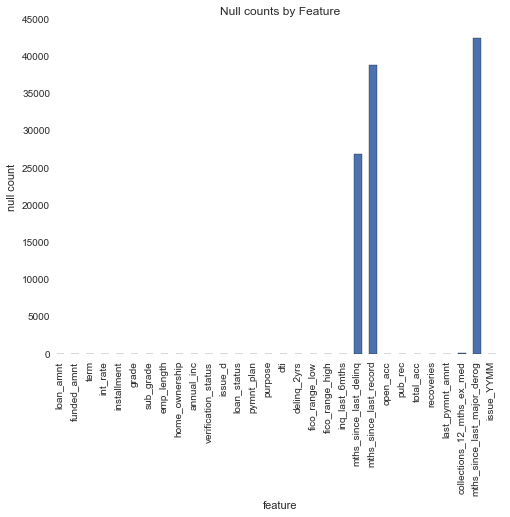

In [6]:
# Plot the isnulls()....

lcd_nulls=[]
features = lcd.columns
x_axis = np.arange(len(lcd.columns))

bar_width =0.5

# Figure out the count of nulls per feature
for r in lcd.columns:
        lcd_nulls.append(lcd[r].isnull().sum())
        
# Make a bar chart
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_axis, lcd_nulls,width=bar_width)
plt.xticks(x_axis+bar_width/2,features,rotation=90)
plt.xlabel('feature')
plt.ylabel('null count')
plt.title('Null counts by Feature')

Conclusion based on the above graph is that 3 features "mnths_since_last_delinq", "mnths_since_last_record",
mnths_since_last_major_derog contain NaN as a way of transmitting information - specifically
There was no activity for the feature described. 
All the other features have Nan occur sufficiently infrequently that we can assume that it is a data problem and 
Hence can use dropna() is needed.

In [5]:
# Drop certain features we don't need for now, and create a new dataframe 
lcd = lcd_raw_clean.drop(['id','member_id','url', 'desc','title','emp_title','addr_state','zip_code',
                   'funded_amnt_inv','revol_bal','revol_util','out_prncp','out_prncp_inv','total_pymnt',
                   'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','collection_recovery_fee',
                   'last_fico_range_high','last_fico_range_low','initial_list_status','policy_code',
                   'earliest_cr_line','next_pymnt_d','last_credit_pull_d','last_pymnt_d'], axis=1)


In [3]:
# Parse Month, Year into calculated feature column for later grouping
lcd_raw_clean.issue_d.fillna(method='backfill',inplace = True)
lcd_raw_clean['issue_YYMM'] = lcd_raw_clean['issue_d'].apply(lambda x: x.strftime('%Y%m'))

Axes(0.125,0.125;0.775x0.775)


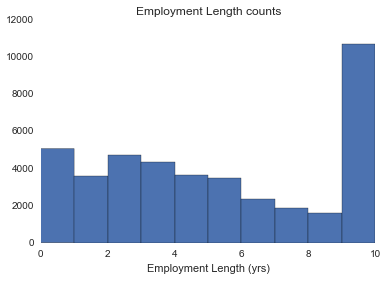

In [7]:
#  Convert Field Employment Length into a classifier
#lcd.emp_length.unique()
#array(['10+ years', , '1 year', '3 years', '8 years', '9 years',
#        '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)
lcd['emp_length_numeric'] = lcd['emp_length'].map({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, 
                                                  '4 years':4,'5 years':5,'6 years':6,'7 years':7,
                                                  '8 years':8,'9 years':9,'10+ years':10})

print lcd['emp_length_numeric'].hist()
plt.title('Employment Length counts')
plt.xlabel('Employment Length (yrs)')

Employment length reasonably evenly distributed out to 5 years.    How is this distributed versus FICO score?

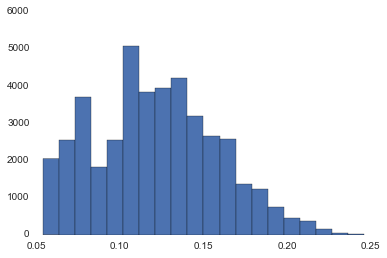

In [9]:
# Strip chars, convert int_rate series to float
lcd.int_rate.fillna(method='backfill',inplace = True)
lcd['clean_rates'] = [float(t.strip(' %'))/100 for t in lcd.int_rate]

# Now plot!
lcd['clean_rates'].hist(bins=20)

In [8]:
# clean term by splitting on spaces and converting numbers into float
lcd.term.fillna(method='backfill',inplace = True)
lcd['clean_term'] = [float (s.split(' ')[1]) for s in lcd.term]

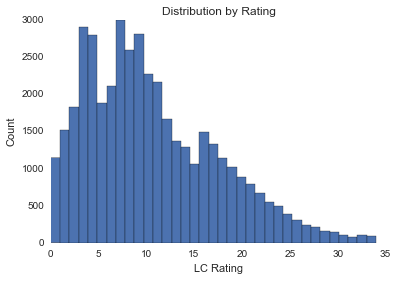

In [13]:
# print lcd['sub_grade'].unique()
#['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
# 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5' 'G4' 'E2'
# 'G3' 'G2' 'G1' 'F5' 'G5']

lcd['sub_grade_int']=lcd['sub_grade'].map({'A1':0,'A2':1,'A3':2,'A4':3,'A5':4,
                                           'B1':5,'B2':6,'B3':7,'B4':8,'B5':9,
                                           'C1':10,'C2':11,'C3':12,'C4':13,'C5':14,
                                           'D1':15,'D2':16,'D3':17,'D4':18,'D5':19,
                                           'E1':20,'E2':21,'E3':22,'E4':23,'E5':24,
                                           'F1':25,'F2':26,'F3':27,'F4':28,'F5':29,
                                           'G1':30,'G2':31,'G3':32,'G4':33,'G5':34})

plt.xlabel('LC Rating')
plt.ylabel('Count')
plt.title('Distribution by Rating')
# X_Axis_Labels = ('A1','A2','A3','A4','A5','B1','B2','B3','B4','B5',
#                 'C1','C2','C3','C4','C5','D1','D2','D3','D4','D5',
#                 'E1','E2','E3','E4','E5','F1','F2','F3','F4','F5',
#                 'G1','G2','G3','G4','G5')
# x_axis = np.arange(len(X_Axis_Labels))
# plt.xticks(x_axis,X_Axis_Labels,rotation=90)
# plt.figure(figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
lcd['sub_grade_int'].hist(bins=35)                             

In [15]:
# print lcd['is_inc_v'].unique()
# ['Verified' 'Source Verified' 'Not Verified']

# backfill all NAs...in theory this might create some problems, but there aren't enough NAs to bias results. 
lcd['verification_status'].fillna(method='backfill',inplace = True)
lcd['verification_status_b'] = (lcd['verification_status']== 'VERIFIED - income') | (lcd['verification_status'] =='VERIFIED - income source')

In [10]:
#  This cell converts dates into a date format

import datetime as dt
# make new data frame and drop all na for last pymnt date
lcd_temp = lcd_raw_clean.drop(lcd_raw_clean[lcd_raw_clean['last_pymnt_d'].isnull()].index)

# ['last_pymnt_d','issue_d','last_credit_pull_d','last_pymnt_d','next_pymnt_d'
lcd_temp['last_pymnt_date'] = [dt.datetime.date(t) for t in lcd_temp.last_pymnt_d]
lcd_temp['issue_date']= [dt.datetime.date(t) for t in lcd_temp.issue_d]
lcd_temp['last_credit_pull_down'] = [dt.datetime.date(t) for t in lcd_temp.last_credit_pull_d]
lcd_temp['next_pymnt_date'] = [dt.datetime.date(t) for t in lcd_temp.next_pymnt_d]

# lcd_temp['days_from_last_pymnt'].hist(bins=20,figsize=(12,9))

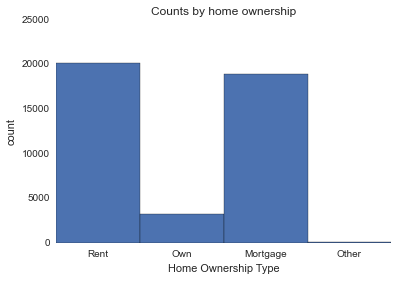

In [14]:
# Convert Home ownership into categorical variable and encode using One Hot Encoder

from sklearn.preprocessing import OneHotEncoder

# Map ownership type to categorical variable
lcd['home_ownership_int'] = lcd['home_ownership'].map({'RENT':0, 'OWN':1, 'MORTGAGE':2, 'OTHER':3, 'NONE':3})

lcd['home_ownership_int'].fillna(method = 'backfill', inplace= True)
ohe = OneHotEncoder(sparse=False)

# Use OHE to convert to feature columns 
encoded_ownership_status = ohe.fit_transform(lcd[['home_ownership_int']])

# Now convert to dataframe and add to lcd
ownership_status_columns = ('Rent','Own','Mortgage','Other')
ownership_encoded_dataframe = pd.DataFrame(encoded_ownership_status, columns=ownership_status_columns)

lcd = pd.concat([ownership_encoded_dataframe, lcd],axis=1)

# Plot the ownership distribution
bar_width = 1.0
x_axis = np.linspace(0,3,num=4)
plt.bar(x_axis,(ownership_encoded_dataframe['Rent'].sum(),ownership_encoded_dataframe['Own'].sum(),
                ownership_encoded_dataframe['Mortgage'].sum(),  ownership_encoded_dataframe['Other'].sum()),width=bar_width)
plt.xticks(x_axis+bar_width/2,('Rent', 'Own', 'Mortgage', 'Other'))
plt.xlabel('Home Ownership Type')
plt.ylabel('count')
plt.title('Counts by home ownership')

In [18]:
# print lcd['pymnt_plan'].unique()
# ['n' 'y']

# Set up calculated feature which is boolean
lcd['pymnt_plan_bool']= (lcd['pymnt_plan']=='y').astype(bool)

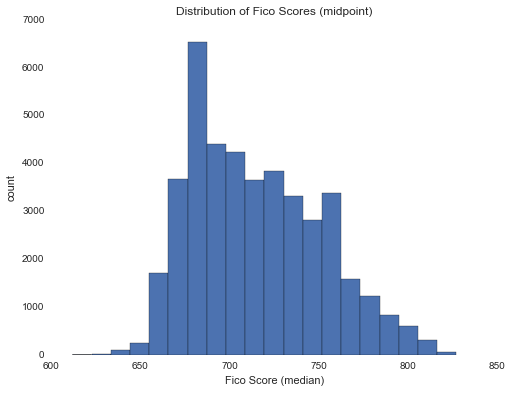

In [19]:
# Define 'fico_interp' as midpoint between fico_range_low and fico_range_high

lcd['fico_interp']=(lcd['fico_range_low']+lcd['fico_range_high'])/2

lcd['fico_interp'].hist(bins=20,figsize=(8, 6))
plt.xlabel('Fico Score (median)')
plt.ylabel('count')
plt.title('Distribution of Fico Scores (midpoint)')

In [158]:
# print lcd['purpose'].unique() 
# ['credit_card' 'car' 'small_business' 'other' 'wedding'
#  'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
#  'moving' 'vacation' 'house' 'renewable_energy' 'educational']

In [20]:
# print lcd['fico_range_low'].unique()
# 
# [ 735.  740.  690.  695.  730.  660.  675.  725.  710.  705.  720.  665.
#   670.  760.  685.  755.  680.  700.  790.  750.  715.  765.  745.  770.
#  780.  775.  795.  810.  800.  815.  785.  805.  825.  820.  630.  625.
#  650.  655.  645.  640.  635.  610.  620.  615.]

#  fico_graph = lcd.groupby('fico_range_low')

# ffico_graph.clean_rates.hist()

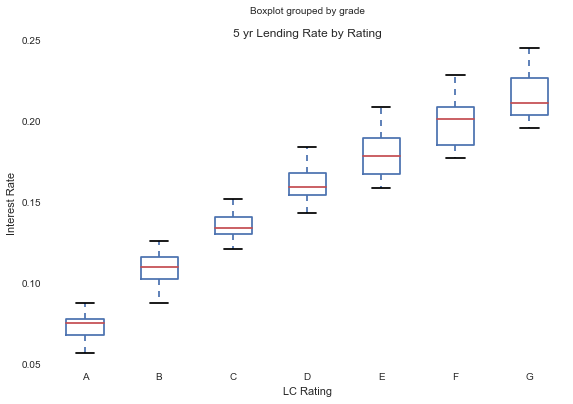

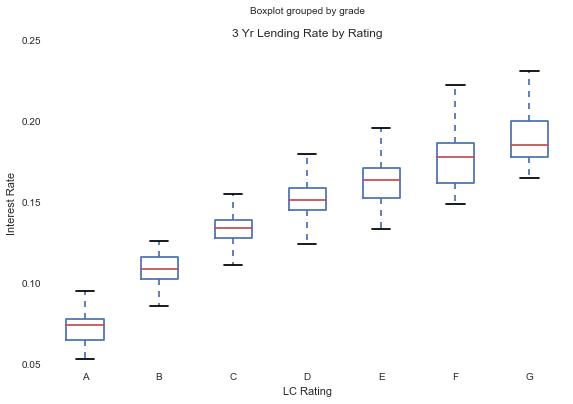

In [11]:
# Make a box chart

# This way is more 'pythonic'
lcd[lcd['clean_term']==60].boxplot(column='clean_rates',by='grade',figsize=(9,6))
plt.xlabel('LC Rating')
plt.ylabel('Interest Rate')
plt.title('5 yr Lending Rate by Rating')

# Old way
# plt.subplot(122)
# lcd_plot3.boxplot(by='grade',figsize=(9, 6))
# More Pythonic
lcd[lcd['clean_term']==36].boxplot(column='clean_rates',by='grade',figsize=(9,6))
plt.xlabel('LC Rating')
plt.ylabel('Interest Rate')
plt.title('3 Yr Lending Rate by Rating')

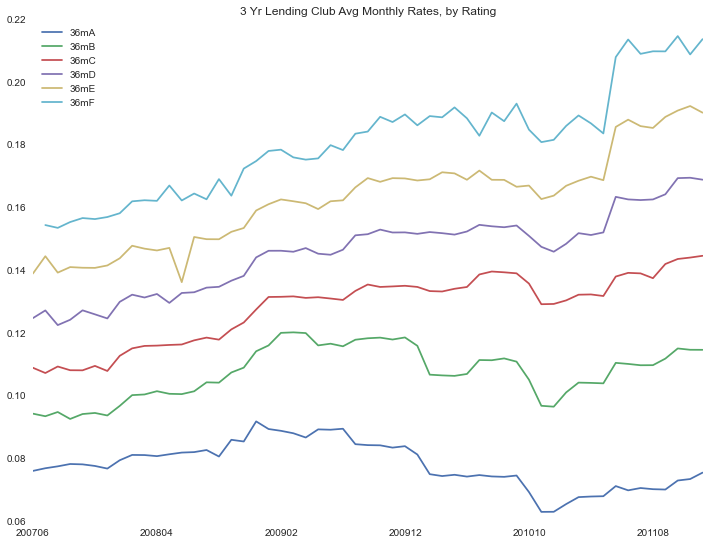

In [12]:
-

In [16]:
# This will become our Response variable (y)
# print lcd['loan_status'].unique()
# ['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
#  'In Grace Period' 'Late (16-30 days)'
# 'Does not meet the credit policy.  Status:Current'
# 'Does not meet the credit policy.  Status:Charged Off'
# 'Does not meet the credit policy.  Status:Fully Paid'
# 'Does not meet the credit policy.  Status:Late (16-30 days)'
# 'Does not meet the credit policy.  Status:In Grace Period'
# 'Does not meet the credit policy.  Status:Late (31-120 days)']

# Create a calculated feature which simplifies the accounting.   
# Fold anything <30 days delinquent into current
# Fold any other delinquency not defaulted into delinquent
# Fold 'Does not meet the Credit Policy' into similar category for other loans
# Fold 'Charged Off' into 'Default'

# 0 = Fully paid/Current
# 1 = Delinquent
# 2 = Defalt/Charged Off

lcd['loan_status_int']=lcd['loan_status'].map({'Fully Paid':0,'Charged Off':2,'Current':0,'Default':2,
                            'Late (31-120 days)':1,'In Grace Period':0,'Late (16-30 days)':1,
                            'Does not meet the credit policy.  Status:Current':0,
                            'Does not meet the credit policy.  Status:Charged Off':2,
                            'Does not meet the credit policy.  Status:Fully Paid':0,
                            'Does not meet the credit policy.  Status:Late (16-30 days)':1,
                            'Does not meet the credit policy.  Status:In Grace Period':0,
                            'Does not meet the credit policy.  Status:Late (31-120 days)':1,
                            'Does not meet the credit policy.  Status:Default' :2})                     


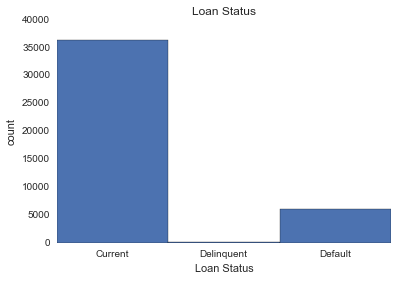

In [17]:
# Convert loan status by using One Hot Encoder (OHE)

ohe = OneHotEncoder(sparse=False)

# THere's only one na, so this shouldn't bias our results tremendously...
lcd['loan_status_int'].fillna(method = 'backfill', inplace= True)

# Use OHE to create multiple features out of loan_status_int
encoded_loan_status = ohe.fit_transform(lcd[['loan_status_int']])

# Create a dataframe to add to lcd
loan_status_columns = ('Current','Delinquent','Default')
encoded_dataframe = pd.DataFrame(encoded_loan_status, columns=loan_status_columns)

# Concat this to lcd. 
lcd = pd.concat([lcd, encoded_dataframe], axis=1)

# Graph the features. 
bar_width = 1.0
x_axis = np.linspace(0,2,num=3)
plt.bar(x_axis,(encoded_dataframe['Current'].sum(),encoded_dataframe['Delinquent'].sum(),
                encoded_dataframe['Default'].sum()),width=bar_width)
plt.xticks(x_axis+bar_width/2,('Current', 'Delinquent', 'Default'))
plt.xlabel('Loan Status')
plt.ylabel('count')
plt.title('Loan Status')

In [49]:
# Create a test and train set from original data
# For now we'll just use two features - 

X_Columns = ['fico_interp', 'dti','clean_rates','loan_amnt','emp_length_numeric']
X = lcd[X_Columns].fillna(method ='backfill')
y = lcd['Default']

# Create train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.70,random_state=123)


In [32]:
# Let's try to visualize features correlated to default.
# First, take xtrain, ytrain and create two dataframes depending on default status
# train = pd.DataFrame(Xtrain, columns = X.columns)
# train['default'] = ytrain
# train_nd = train[train['default']==0]
# train_d = train[train['default']==1]
# print Xtrain.shape
# plt.figure(figsize=(12,9))

#  plt.scatter(train_nd.fico_interp, train_nd.dti, alpha= 0.75,marker='+', c= 'b')
# plt.scatter(train_d.fico_interp, train_d.dti, marker='o', edgecolors = 'r', facecolors = 'none')
# plt.legend( ('no default', 'default'), loc='upper right')

In [23]:
train_nd.describe()

,fico_interp,dti,default
count,10900.000000,10900.000000,10900
mean,717.708257,13.187894,0
std,36.869148,6.724877,0
min,627.000000,0.000000,0
25%,687.000000,8.000000,0
50%,712.000000,13.190000,0
75%,742.000000,18.462500,0
max,822.000000,29.920000,0


In [24]:
train_d.describe()

,fico_interp,dti,default
count,1860.000000,1860.000000,1860
mean,703.666667,14.108167,1
std,32.733896,6.671441,0
min,617.000000,0.000000,1
25%,677.000000,9.167500,1
50%,697.000000,14.535000,1
75%,727.000000,19.385000,1
max,822.000000,29.960000,1


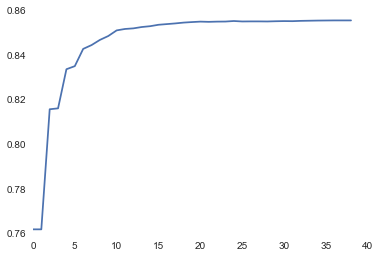

In [57]:
#  Use KNN to start...
from sklearn import neighbors

scores = []
for k in range(1, 40):
    clf = neighbors.KNeighborsClassifier(k, weights='distance')
 
    clf.fit(Xtrain, ytrain);

    scores.append(clf.score(Xtest, ytest))

plt.plot(scores)

ypred = clf.predict(Xtest)


In [58]:
from sklearn import metrics

conf_matrix = metrics.confusion_matrix(ypred, ytest)
pd.DataFrame(conf_matrix, columns=['Pred ND', 'Pred D'], index=['Actual ND', 'Actual D'])

,Pred ND,Pred D
Actual ND,25488,4282
Actual D,4,0


,fico_interp,dti,clean_rates,loan_amnt,emp_length_numeric
count,4.253400e+04,4.253400e+04,4.253400e+04,4.253400e+04,4.253400e+04
mean,1.464720e-15,-1.443337e-16,4.116183e-16,1.069138e-17,2.138277e-17
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-2.847710e+00,-1.988269e+00,-1.819287e+00,-1.428937e+00,-1.381516e+00
25%,-7.751508e-01,-7.691609e-01,-6.838325e-01,-7.947404e-01,-8.209786e-01
50%,-8.429790e-02,1.433916e-02,-4.733087e-02,-1.875309e-01,-2.604414e-01
75%,7.447256e-01,7.889189e-01,6.889613e-01,5.276270e-01,1.140902e+00
max,3.093626e+00,2.470396e+00,3.350941e+00,3.226336e+00,1.421170e+00


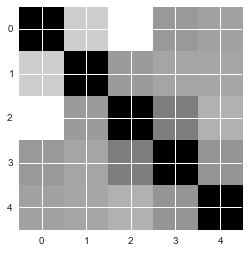

In [52]:
# Create Scaled features and supply to KNN.
from sklearn import preprocessing

scaled_features = preprocessing.scale(X)

# Create new dataframes from scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)
y = lcd['Default']

plt.imshow(X_scaled.corr(), interpolation='nearest');

## TODO: Scatter matrix plot:
# pd.scatter_matrix(wine_features, c=y, figsize=(20, 20), s=120, cmap='brg');

# Scaler applies 0 mean and unit variance:
X_scaled.describe()

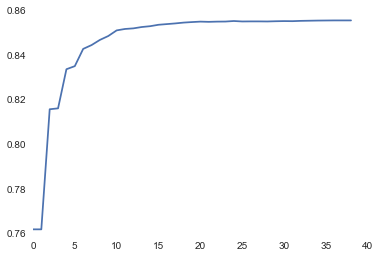

In [54]:
#  Use KNN to start...
# from sklearn import neighbors
# X_KNN = pd.concat(['X_scaled',

# Create train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled,y,test_size=0.70,random_state=123)

scores = []
for k in range(1, 40):
    clf = neighbors.KNeighborsClassifier(k, weights='distance')
 
    clf.fit(Xtrain, ytrain);

    scores.append(clf.score(Xtest, ytest))

plt.plot(scores)

y_pred = clf.predict(Xtest)

In [29]:
#  Calculate a logistic regression against the 2 features for now. 
# Use Cross Validation to create train, test samples from data

import sklearn
import sklearn.linear_model as lm
import sklearn.grid_search as gs

# Use grid search to search for best parameters

# kf = sklearn.cross_validation.KFold(n=len(X), n_folds=3, shuffle=True, random_state=1234)

#  Run a logistic regression on each of the folds, and predict y
logreg = lm.LogisticRegression()
logreg.fit(Xtrain, ytrain)
print logreg.coef_
print logreg.intercept_

[[ -7.77012945e-03  -4.22985481e-03   9.25099982e+00]]
[ 0.06029801]


In [30]:
# Use grid search to estimate best parameters....
# Want to include AUC as a score function? 


parameters = {'C':[float (n)/100 for n in range(1,101,1)]}
gs_result = gs.GridSearchCV(logreg,parameters)
gs_result.fit(Xtrain,ytrain)

# Use F1 scores and AUC scores

print gs_result.best_params_
print gs_result.best_estimator_
print gs_result.best_score_

{'C': 0.01}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
1.0


In [31]:
Y_Pred = gs_result.predict(Xtest)

ValueError: X has 2 features per sample; expecting 3

In [201]:
import statsmodels.formula.api as smf

kf = sklearn.cross_validation.KFold(n=len(X), n_folds=3, shuffle=True, random_state=1234)
smf.logit('default ~ fico_interp + dti',train).fit()

print logreg.get_params()
print logreg.coef_
# for train, test in kf:   
#   logreg.fit(X.iloc[train],np.ravel(y.iloc[train]))
#    ypredicted = logreg.predict(X.iloc[test])
#    print logreg.coef_
#    print logreg.score(X.iloc[test],y.iloc[test])
    

# setting alpha to 0 effectively removes the hyperparameter
# results = lmf.fit_regularized(alpha=0)
# print results.summary()
# print np.exp(results.params)

Optimization terminated successfully.
         Current function value: 0.405283
         Iterations 6
{'C': 1.0, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': None, 'dual': False, 'tol': 0.0001, 'solver': 'liblinear', 'class_weight': None}
[[ -7.77012945e-03  -4.22985481e-03   9.25099982e+00]]


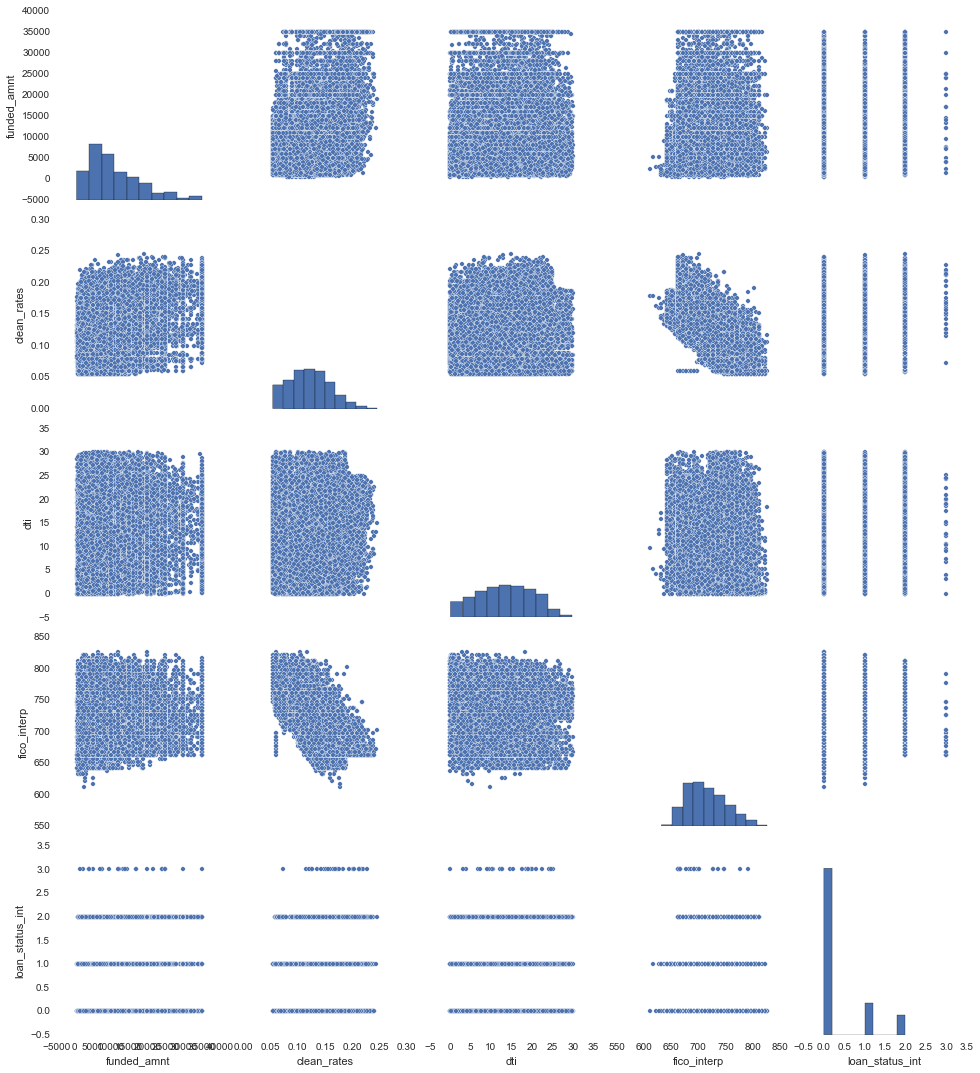

In [89]:
# Scatter plot a subset of certain selected features. 
# convert the 'train' data back into a dataframe
lcd_small = pd.DataFrame(train,columns=lcd.columns)

# pd scatter_matrix doesn't work, but sns does.... why? 
# pd.scatter_matrix(lcd_small[['loan_amnt', 'funded_amnt','int_rate']], figsize=(18, 18), alpha=0.05, diagonal='kde')
sns.pairplot(data=lcd_small[['funded_amnt','clean_rates','grade','home_ownership',
                          'dti','fico_interp','loan_status_int']], aspect=0.90, dropna=True)